`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   

# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг. 

#### Работу выполнила студентка ПМИ3-1 Марахова Екатерина, вариант №13.

В практических примерах ниже показано:   

* как делать перекодировку признаков в номинальной и порядковой шкалах
* как вырастить дерево и сделать обрезку его ветвей   
* как настроить модель бэггинга   
* как вырастить случайный лес  
* как настроить модель бустинга на деревьях решений  
* как подбирать настроечные параметры моделей методом сеточного поиска  

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: множественная линейная регрессия 

*Данные*: `default_of_credit_card_clients` (источник: [репозиторий](https://github.com/aksyuk/MTML/blob/main/Labs/data/default_of_credit_card_clients.csv))

*Объясняющие переменные*: все, кроме Y

*Метод, основанный на деревьях решений*: бэггинг

# Указания к выполнению


## Загружаем пакеты

In [384]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency, t
#  для таймера
import time


# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
#  сводка по точности классификации
from sklearn.metrics import classification_report


In [385]:
# константы
#  ядро для генератора случайных чисел
my_seed = 13
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [386]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

Данные по кредитам 30000 клиентов банков Тайваня (статистика 2005 года). 

`Задача`: спрогнозировать дефолт платежа в следущем месяце по статистике за 6 предыдущих месяцев и по общим сведениям о клиенте. 

`Источник данных`: статья Yeh, I. C., & Lien, C. H. The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480. (Набор данных был загружен из репозитория [UCI](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)).

### Список столбцов файла: 
* `LIMIT_BAL` – размер выданного кредита (новых тайваньских долларов);  
  
  
* `SEX` – пол:  
1 = мужской,   
2 = женский;   

  
* `EDUCATION` – образование:  
1 = аспирантура,   
2 = университет,   
3 = старшая школа,   
4 = другое;  
  
  
* `MARRIAGE` – семейное положение:   
1 = женат/замужем,   
2 = одинок,   
3 = другое;  
  
  
* `AGE` – возраст, лет;  
  
  
* `PAY_0, PAY_2,PAY_3, PAY_4, PAY_5, PAY_6` – статус последних ежемесячных платежей, с сентября (`PAY_0`) по апрель (`PAY_6`) 2005 года:   
\-1 = платёж внесён вовремя,   
1 = платёж внесён с опозданием на 1 месяц;   
2 = с опозданием на 2 месяца,   
и т.д.,   
9 = с опозданием на 9 месяцев и более;  
  
  
* `BILL_AMT1, ..., BILL_AMT6` – размер последних ежемесячных платежей (новых тайваньских долларов), с сентября (`BILL_AMT1`) по апрель (`BILL_AMT6`) 2005 года;  
  
  
* `PAY_AMT1, ..., PAY_AMT6` – размер ежемесячных платежей в предыдущем месяце (новых тайваньских долларов), с сентября (`PAY_AMT1` за август) по апрель (`PAY_AMT6` за март) 2005 года;  
  
  
* `Y` – целевая переменная: дефолт в следующем месяце (1 – да, 0 – нет).


Загружаем данные во фрейм и выясняем их размерность. 

In [387]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/default_of_credit_card_clients.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

# смотрим на данные
DF_raw.iloc[:, :12].head(5)

Число строк и столбцов в наборе данных:
 (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913
1,120000,2,2,2,26,-1,2,0,0,0,2,2682
2,90000,2,2,2,34,0,0,0,0,0,0,29239
3,50000,2,2,1,37,0,0,0,0,0,0,46990
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617


In [388]:
DF_raw.iloc[:, 12:].head(5)

,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,3102,689,0,0,0,0,689,0,0,0,0,1
1,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [389]:
# типы столбцов
DF_raw.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

Функция построения дерева классификации `DecisionTreeClassifier()` требует числовых порядковых значений переменных, поэтому наши данные полностью подходят.

In [390]:
DF.isna().sum()

LIMIT_BAL      0
AGE            0
PAY_0          0
PAY_2          0
PAY_3          0
PAY_4          0
PAY_5          0
PAY_6          0
BILL_AMT1      0
BILL_AMT2      0
BILL_AMT3      0
BILL_AMT4      0
BILL_AMT5      0
BILL_AMT6      0
PAY_AMT1       0
PAY_AMT2       0
PAY_AMT3       0
PAY_AMT4       0
PAY_AMT5       0
PAY_AMT6       0
Y              0
SEX_1          0
EDUCATION_1    0
EDUCATION_2    0
EDUCATION_3    0
MARRIAGE_1     0
MARRIAGE_2     0
dtype: int64

# Предварительный анализ данных. Описательные статистики.

##  Подсчет частот категориальных значений.

In [391]:
DF.Y.unique()

array([0, 1])

In [392]:
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.781
1    0.219
Name: Y, dtype: float64

In [393]:
DF_raw['SEX'].unique()

array([2, 1])

In [394]:
np.around(DF_raw.SEX.value_counts() / len(DF_raw.index), 3)

2    0.604
1    0.396
Name: SEX, dtype: float64

In [395]:
DF_raw['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [396]:
np.around(DF_raw.EDUCATION.value_counts() / len(DF_raw.index), 3)

2    0.468
1    0.353
3    0.164
5    0.009
4    0.004
6    0.002
0    0.000
Name: EDUCATION, dtype: float64

In [397]:
DF_raw['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [398]:
np.around(DF_raw.MARRIAGE.value_counts() / len(DF_raw.index), 3)

2    0.532
1    0.455
3    0.011
0    0.002
Name: MARRIAGE, dtype: float64

## ХИ-КВАДРАТ
### Y и SEX


In [399]:
df_Y_SEX = pd.crosstab(DF_raw['Y'], DF_raw['SEX'])
df_Y_SEX

SEX,1,2
Y,,
0,9015,14349
1,2873,3763


In [400]:
list_Y_SEX = [[df_Y_SEX[1][0], df_Y_SEX[2][0]], 
              [df_Y_SEX[1][1], df_Y_SEX[2][1]]]
list_Y_SEX

[[9015, 14349], [2873, 3763]]

In [401]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(list_Y_SEX)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi2, df, prob))
print(expected)

test Statistics: 47.70879689062111
degrees of freedom: 1
p-value: 4.944678999412044e-12

[[ 9258.3744 14105.6256]
 [ 2629.6256  4006.3744]]


### Y и EDUCATION

In [402]:
df_Y_EDUCATION = pd.crosstab(DF_raw['Y'], DF_raw['EDUCATION'])
df_Y_EDUCATION

EDUCATION,0,1,2,3,4,5,6
Y,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


In [403]:
list_Y_EDUCATION = [[df_Y_EDUCATION[1][0], df_Y_EDUCATION[2][0], 
                     df_Y_EDUCATION[3][0], df_Y_EDUCATION[4][0], 
                     df_Y_EDUCATION[5][0], df_Y_EDUCATION[6][0]], 
                    
                    [df_Y_EDUCATION[1][1], df_Y_EDUCATION[2][1], 
                     df_Y_EDUCATION[3][1], df_Y_EDUCATION[4][1], 
                     df_Y_EDUCATION[5][1], df_Y_EDUCATION[6][1]]]
list_Y_EDUCATION

[[8549, 10700, 3680, 116, 262, 43], [2036, 3330, 1237, 7, 18, 8]]

In [404]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(list_Y_EDUCATION)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi2, df, prob))
print(expected)

test Statistics: 159.18512540464334
degrees of freedom: 5
p-value: 1.4764557605044473e-32

[[ 8242.50483559 10925.11505369  3828.85179751    95.77969719
    218.03508304    39.71353298]
 [ 2342.49516441  3104.88494631  1088.14820249    27.22030281
     61.96491696    11.28646702]]


### Y и MARRIAGE

In [405]:
df_Y_MARRIAGE = pd.crosstab(DF_raw['Y'], DF_raw['MARRIAGE'])
df_Y_MARRIAGE

MARRIAGE,0,1,2,3
Y,,,,
0,49,10453,12623,239
1,5,3206,3341,84


In [406]:
list_Y_MARRIAGE = [[df_Y_MARRIAGE[1][0], df_Y_MARRIAGE[2][0], 
                     df_Y_EDUCATION[3][0]], 
                    
                    [df_Y_MARRIAGE[1][1], df_Y_MARRIAGE[2][1], 
                     df_Y_MARRIAGE[3][1]]]

In [407]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(list_Y_MARRIAGE)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi2, df, prob))
print(expected)

test Statistics: 858.2880051332515
degrees of freedom: 2
p-value: 4.2182055954096444e-187

[[10946.18276575 12793.38616827  3016.43106598]
 [ 2712.81723425  3170.61383173   747.56893402]]


### Описательные статистики для непрерывных переменных набора.

In [408]:
DF_raw.iloc[:, :1].describe()

,LIMIT_BAL
count,30000.000000
mean,167484.322667
std,129747.661567
min,10000.000000
25%,50000.000000
50%,140000.000000
75%,240000.000000
max,1000000.000000


In [409]:
DF_raw.iloc[:, 4:11].describe()

,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [410]:
DF.iloc[:, 11:20].describe()

,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000
mean,43011.959020,40047.777804,38657.944118,5721.081059,5.912399e+03,5195.790706,4851.610588,4847.703137,5248.818863
std,63681.324672,60026.412733,59003.614301,16819.669309,2.259416e+04,16745.180224,15980.476266,15559.835697,17901.580110
min,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2280.000000,1740.750000,1242.000000,1000.000000,8.360000e+02,390.000000,298.750000,243.750000,108.750000
50%,19010.000000,18067.000000,17001.500000,2111.500000,2.010000e+03,1826.500000,1500.000000,1500.000000,1500.000000
75%,54429.500000,50065.250000,49162.750000,5015.000000,5.000000e+03,4512.750000,4027.000000,4064.250000,4000.000000
max,706864.000000,587067.000000,699944.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000


**Выводы по описательным статистикам**: некоторые минимумы значений принимают отрицательные значения, а стандартные отклонения имеют очень большие значения и достаточно большой разброс, что говорит о неоднородности данных. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Создание фиктивных переменных.

In [411]:
DF_copy = DF_raw.copy()
categorical_cols = ['SEX','EDUCATION','MARRIAGE']
DF_copy = pd.get_dummies(DF_copy, columns = categorical_cols)

In [412]:
DF_copy.iloc[:, :17].head(5)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0
1,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000
2,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000
3,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200
4,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000


In [413]:
DF_copy.iloc[:, 17:].head(5)

,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0
1,1000,0,2000,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,1000,1000,5000,0,0,1,0,0,1,0,0,0,0,0,0,1,0
3,1100,1069,1000,0,0,1,0,0,1,0,0,0,0,0,1,0,0
4,9000,689,679,0,1,0,0,0,1,0,0,0,0,0,1,0,0


In [414]:
#SEX_1 - мужской пол

#удаляем лишние фиктивные
DF_copy = DF_copy.drop('SEX_2', axis=1)
#в образовании появляются новые переменные 0, 5 и 6 их тоже удаляем
DF_copy = DF_copy.drop('EDUCATION_0', axis=1)
DF_copy = DF_copy.drop('EDUCATION_4', axis=1)
DF_copy = DF_copy.drop('EDUCATION_5', axis=1)
DF_copy = DF_copy.drop('EDUCATION_6', axis=1)
#в семейном положении появляется новая переменная 0 ее тоже удаляем
DF_copy = DF_copy.drop('MARRIAGE_0', axis=1)
DF_copy = DF_copy.drop('MARRIAGE_3', axis=1)

### Отложим 15% наблюдений для прогноза.

In [415]:
# наблюдения для моделирования
DF = DF_copy.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_copy.drop(DF.index)
DF_predict = DF_copy.drop(DF.Y)

## Визуализация разброса переменных внутри классов
Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.

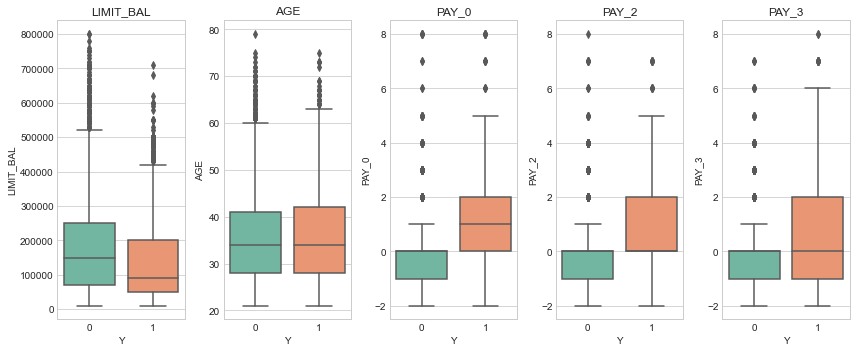

In [416]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    #g = sns.barplot(x='Y', y=col_name, data=DF, ax=axs[i])
    #g.set_yscale("log")
    
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

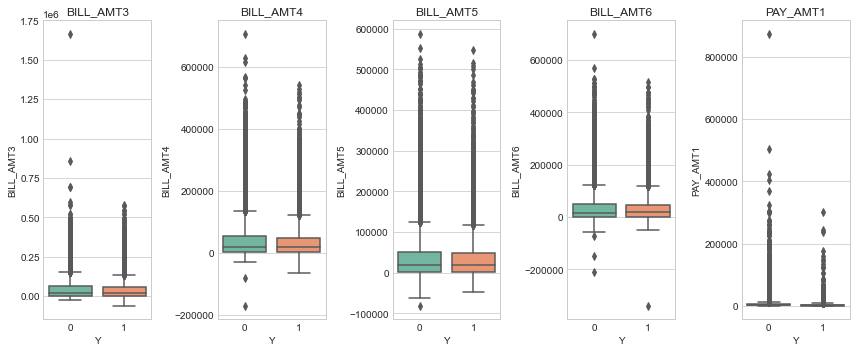

In [417]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[10:15].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    #g = sns.barplot(x='Y', y=col_name, data=DF, ax=axs[i])
    #g.set_yscale("log")
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

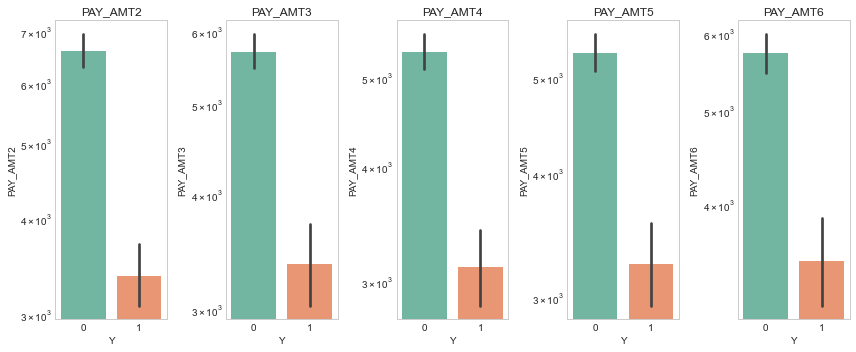

In [418]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[15:20].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    #sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    g = sns.barplot(x='Y', y=col_name, data=DF, ax=axs[i])
    g.set_yscale("log")
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

Только на графиках `PAY_0` и `PAY_2` можно наблюдать хорошее разделение по классам, остальные практически не различаются. Это говорит о том, классы по зависимой переменной `Y` плохо разделяются по всем объясняющим переменным.  

## Корреляционный анализ
Теперь посмотрим на взаимодействие объясняющих переменных.  

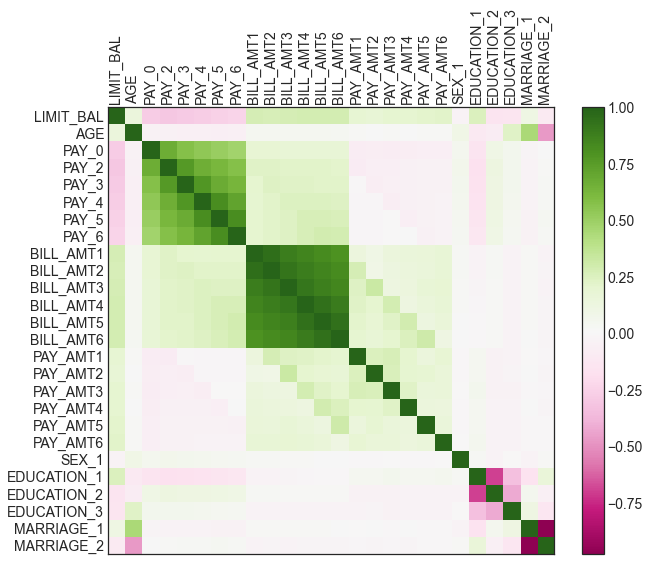

In [419]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

#### Вывод по тепловой карте

Более тесные положительные связи прослеживаются между переменными `BILL_AMT1, BILL_AMT1, ..., BILL_AMT6`, чуть менее тесные положительные - `PAY_0, PAY_1, ..., PAY_6`. 

Также видно и тесные отрицательные связи между `SEX_1` и `SEX_2`, а также `MARRIAGE_1` и `MARRIAGE_2`.

In [420]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
324,MARRIAGE_1,MARRIAGE_2,-0.975374,0.0
315,EDUCATION_1,EDUCATION_2,-0.690309,0.0
48,AGE,MARRIAGE_2,-0.466652,0.0
319,EDUCATION_2,EDUCATION_3,-0.415212,0.0
316,EDUCATION_1,EDUCATION_3,-0.328761,0.0
...,...,...,...,...
205,BILL_AMT3,BILL_AMT4,0.920791,0.0
189,BILL_AMT2,BILL_AMT3,0.925152,0.0
220,BILL_AMT4,BILL_AMT5,0.938409,0.0
234,BILL_AMT5,BILL_AMT6,0.944524,0.0


Как и было сказано выше, самая сильная обратная связь между `MARRIAGE_1` и `MARRIAGE_2`, а прямая между `BILL_AMT1` и `BILL_AMT2`.

# Модель дерева  

В этом разделе построим:  

* дерево классификации  
* дерево классификации с обрезкой ветвей  


## Дерево на всех признаках    

Построим модель и выведем изображение дерева в виде текста.  

In [421]:
# выращиваем дерево на всех объясняющих
X = DF.drop(['Y'], axis=1)
y = DF['Y']

# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)

# выводим количество листьев (количество конечных узлов)
tree_full.get_n_leaves()

3650

In [422]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
tree_full.get_depth()

59

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.   

In [423]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
                     scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.732


## Дерево с обрезкой ветвей   

Подберём оптимальное количество ветвей, которое максимизирует $Acc$, для экономии времени рассчитанный методом проверочной выборки.  

In [424]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 1621
Энтропия листьев для первых 5 значений alpha: [0.00126528 0.00128451 0.00130373 0.00135256 0.00140139]


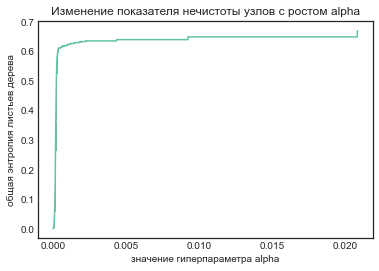

In [425]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker=',', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [431]:
# обучающая и тестовая выборки, чтобы сэкономить время
my_seed= 9213
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=my_seed)

# модели
clfs = list()

# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 760.98 секунд


In [432]:
# извлекаем характеристики глубины и точности
#  таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
#  таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 19.40 секунд


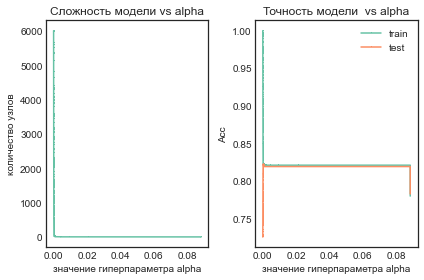

In [433]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)

# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")

# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели  vs alpha")
ax[1].legend()
fig.tight_layout()

Находим оптимальный размер дерева по максимуму $Acc$ на тестовой выборке.  

In [434]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
                    scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')

print('Оптимальное количество узлов:', opt_nodes_num,
      '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
      '\n\nAcc с перекрёстной проверкой',
      '\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 45 
соответствующая Acc на тестовой: 0.822 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.745


Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

In [435]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

2030

In [436]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
clfs[opt_nodes_num].get_depth()

34

---

📚 **Пример визуализации небольшого дерева**

Лучшее дерево с обрезкой по-прежнему слишком велико для визуализации. Для примера нарисуем одно из небольших деревьев с обрезкой и выведем его же в виде текста.  

In [437]:
# находим деревья с количеством листьев меньше 20
[i for i in node_counts if i < 20]

[19, 15, 15, 15, 15, 15, 13, 13, 13, 13, 13, 9, 9, 9, 7, 7, 7, 7, 5, 5, 3, 1]

Количество узлов: 19 
Точность дерева на тестовой: 0.819


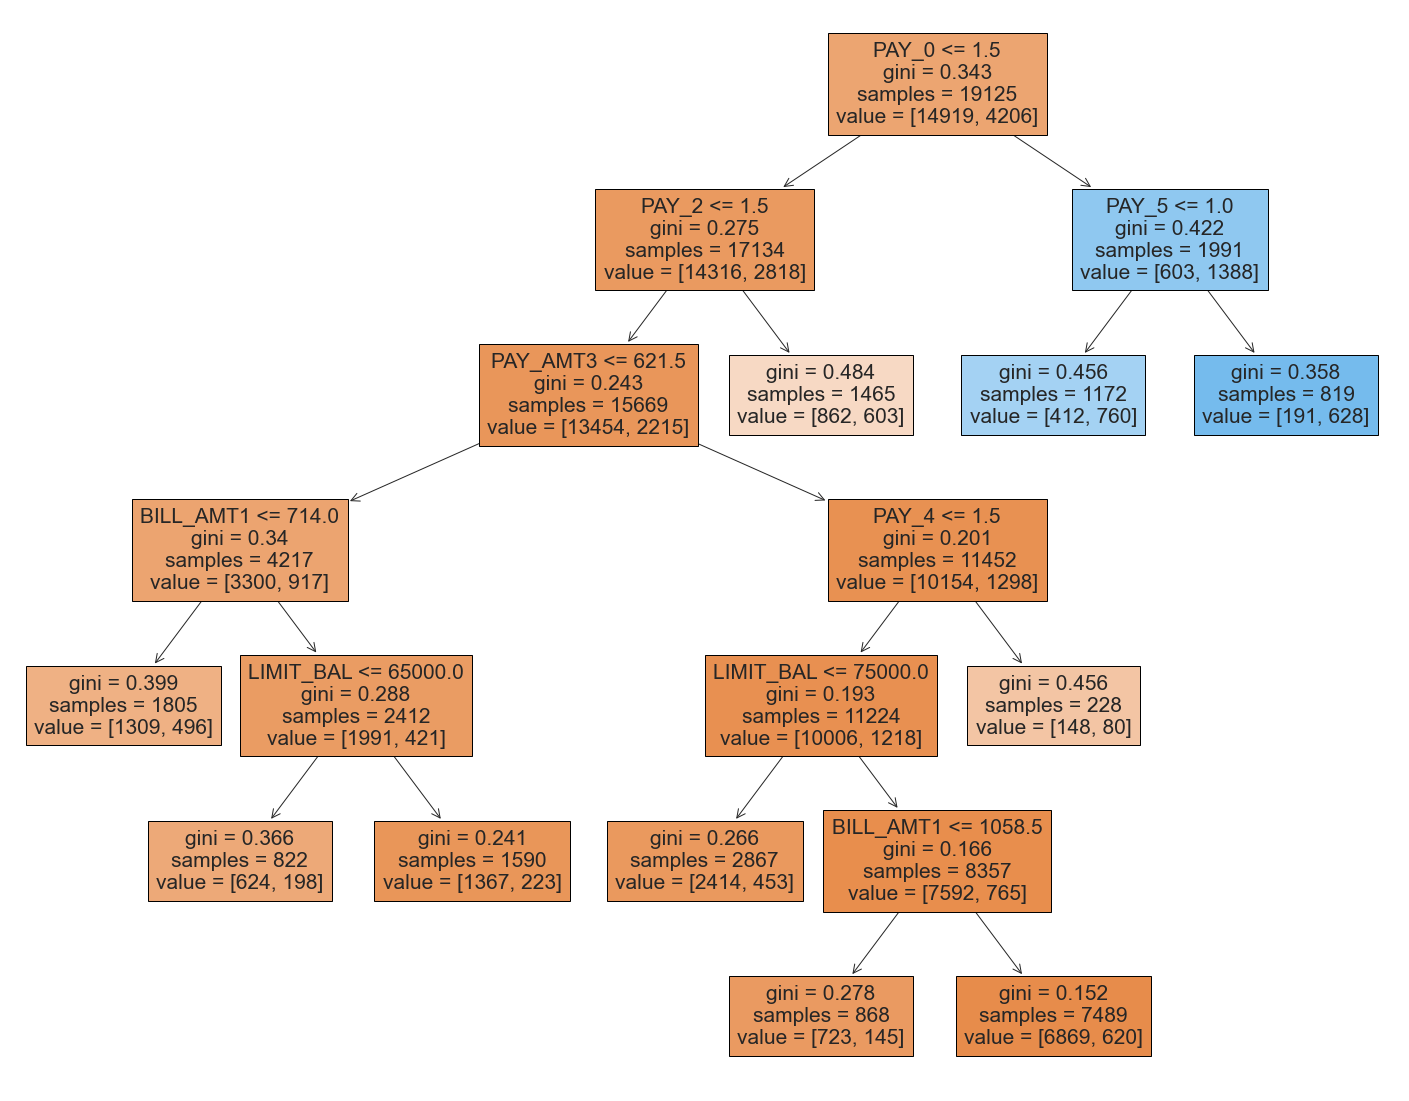

In [439]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = 19
print('Количество узлов:', nodes_num,
      '\nТочность дерева на тестовой:', 
      np.around(test_scores[node_counts.index(nodes_num)], 3))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], 
              filled=True, 
              feature_names=list(X.columns))

In [440]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], 
                  feature_names=list(X.columns))
print(viz)

|--- PAY_0 <= 1.50
|   |--- PAY_2 <= 1.50
|   |   |--- PAY_AMT3 <= 621.50
|   |   |   |--- BILL_AMT1 <= 714.00
|   |   |   |   |--- class: 0
|   |   |   |--- BILL_AMT1 >  714.00
|   |   |   |   |--- LIMIT_BAL <= 65000.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- LIMIT_BAL >  65000.00
|   |   |   |   |   |--- class: 0
|   |   |--- PAY_AMT3 >  621.50
|   |   |   |--- PAY_4 <= 1.50
|   |   |   |   |--- LIMIT_BAL <= 75000.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- LIMIT_BAL >  75000.00
|   |   |   |   |   |--- BILL_AMT1 <= 1058.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- BILL_AMT1 >  1058.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- PAY_4 >  1.50
|   |   |   |   |--- class: 0
|   |--- PAY_2 >  1.50
|   |   |--- class: 0
|--- PAY_0 >  1.50
|   |--- PAY_5 <= 1.00
|   |   |--- class: 1
|   |--- PAY_5 >  1.00
|   |   |--- class: 1



---

# Бэггинг  

Модель бэггинга использует бутстреп, чтобы вырастить $B$ деревьев на выборках с повторами из обучающих данных. Построим модель для $B=50$ деревьев.  

In [441]:
# параметр B: количество деревьев
num_trees = 50

# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# таймер
tic = time.perf_counter()
# модель с бэггингом
tree_bag = BaggingClassifier(base_estimator=cls_one_tree,
                             n_estimators=num_trees,
                             random_state=my_seed)

cv = cross_val_score(tree_bag, X, y, cv=kfold)

# таймер
toc = time.perf_counter()
print(f"Обучение модели с бэггингом на {num_trees:0.0f} деревьях", 
      " и перекрёстной проверкой ", 
      f"заняло {toc - tic:0.2f} секунд", sep='')

Обучение модели с бэггингом на 50 деревьях и перекрёстной проверкой заняло 86.70 секунд


In [442]:
# точность
np.around(np.mean(cv), 3)

0.814

Итак, мы построили модель, выбрав параметр $B$ случайным образом. Воспользуемся функцией `GridSearchCV()`, чтобы перебрать 5 вариантов значений для параметра $B$.  

In [443]:
# настроим параметры бэггинга с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50]}

# таймер
tic = time.perf_counter()
clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
                  param_grid, scoring='accuracy', cv=kfold)

tree_bag = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 258.59 секунд


In [444]:
# точность лучшей модели
np.around(tree_bag.best_score_, 3)

0.814

In [445]:
# количество деревьев у лучшей модели
tree_bag.best_params_

{'n_estimators': 50}

In [446]:
tree_bag.best_estimator_.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Таким образом, перебрав несколько вариантов для $B$, мы немного улучшили первоначальную точность модели бэггинга.  

In [447]:
# записываем точность
score.append(np.around(tree_bag.best_score_, 3))
score_models.append('bagging_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[2], ':', score[2])

Acc с перекрёстной проверкой 
для модели bagging_GS : 0.814



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [448]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.732
1,pruned_tree,0.745
2,bagging_GS,0.814


Все модели показывают среднюю точность по показателю $Acc$, при этом самой точной оказывается модель бэггинга. Сделаем прогноз на отложенные наблюдения.   

In [453]:
# данные для прогноза
X_pred = DF_predict.drop(['Y'], axis=1)
# строим прогноз
y_hat = tree_bag.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     23364
           1       0.97      0.90      0.93      6634

    accuracy                           0.97     29998
   macro avg       0.97      0.95      0.96     29998
weighted avg       0.97      0.97      0.97     29998



# Источники 

1. Джеймс Г., Уиттон Д., Хасти Т., Тибширани Р. Введение в статистическое обучение с примерами на языке R. Пер. с англ. С.Э. Мастицкого – М.: ДМК Пресс, 2016 – 450 с.  
1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. *Tong Wang*, *Cynthia Rudin*, *Finale Doshi-Velez*, *Yimin Liu*, *Erica Klampfl*, *Perry MacNeille* A Bayesian Framework for Learning Rule Sets for Interpretable Classification / Journal of Machine Learning Research 18 (2017) 1-37. URL: <https://jmlr.org/papers/volume18/16-003/16-003.pdf>  
1. *George Pipis* How to Run the Chi-Square Test in Python / medium.com. URL: <https://medium.com/swlh/how-to-run-chi-square-test-in-python-4e9f5d10249d>   
1. *Bernd Klein* What are Decision Trees? / python-course.eu. URL: <https://www.python-course.eu/Decision_Trees.php>  
1. Pruning decision trees - tutorial / kaggle.com. URL: <https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial>  
1. Post pruning decision trees with cost complexity pruning / scikit-learn.org. URL: <https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html>  
1. *Piotr Płoński* Visualize a Decision Tree in 4 Ways with Scikit-Learn and Python / mljar.com. URL: <https://mljar.com/blog/visualize-decision-tree/>  
1. Random Forest Feature Importance Plot / www.analyseup.com. URL: <https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html>  